In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns


In [2]:
building_damage_assessment = pd.read_csv("../csv_files/csv_building_damage_assessment.csv",low_memory=False)
name_mapping = pd.read_csv("../csv_files/ward_vdcmun_district_name_mapping.csv",low_memory=False)


In [3]:
# Create district_id_name_dict
district_id_name_dict = name_mapping.set_index('district_id')['district_name'].to_dict()


In [4]:
duplicates = name_mapping[name_mapping.duplicated(subset='vdcmun_id', keep=False)]
name_mapping = name_mapping.drop_duplicates(subset='vdcmun_id')
name_mapping = name_mapping.groupby('vdcmun_id').agg({
    'vdcmun_name': 'first',
    'district_name': 'first'
}).reset_index()
vdcmun_id_name_dict = name_mapping.set_index('vdcmun_id')[['vdcmun_name', 'district_name']].to_dict('index')



In [5]:
main_df_columns = building_damage_assessment.iloc[:, :54]


In [6]:
# Map vdcmun_id to vdcmun_name and district_name
main_df_columns['vdcmun_name'] = main_df_columns['vdcmun_id'].map(lambda x: vdcmun_id_name_dict[x]['vdcmun_name'])
main_df_columns['district_name'] = main_df_columns['vdcmun_id'].map(lambda x: vdcmun_id_name_dict[x]['district_name'])

# Reorder columns
cols = list(main_df_columns.columns)
cols.insert(cols.index('vdcmun_id'), cols.pop(cols.index('vdcmun_name')))
cols.insert(cols.index('district_id'), cols.pop(cols.index('district_name')))
main_df_columns = main_df_columns[cols]


In [7]:
target_column = 'damage_grade'
cramerV_list = []
processed_df = main_df_columns.iloc[:, :6]
for i in range(6, 55):
    entry_column = main_df_columns.columns[i]
    contingency_table = pd.crosstab(main_df_columns[entry_column], main_df_columns[target_column])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()# Total number of observations
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    if cramers_v > 0.2:
        cramerV_list.append(cramers_v)
        print("Cramér's V:", cramers_v)
        print("Column name is: ", main_df_columns.columns[i])
        processed_df = pd.concat([processed_df, main_df_columns.iloc[:, i]], axis=1)
processed_df = pd.concat([processed_df, main_df_columns[target_column]], axis=1)

Cramér's V: 0.5618371122498683
Column name is:  damage_overall_collapse
Cramér's V: 0.2851951023763733
Column name is:  damage_overall_leaning
Cramér's V: 0.25243262743853423
Column name is:  damage_foundation_severe
Cramér's V: 0.22690109928414273
Column name is:  damage_roof_severe
Cramér's V: 0.2520240002737159
Column name is:  damage_corner_separation_severe
Cramér's V: 0.23537221388176963
Column name is:  damage_diagonal_cracking_severe
Cramér's V: 0.24912822925831293
Column name is:  damage_in_plane_failure_severe
Cramér's V: 0.23494034724518376
Column name is:  damage_out_of_plane_failure_severe
Cramér's V: 0.21416783899299252
Column name is:  damage_out_of_plane_failure_walls_ncfr_severe
Cramér's V: 0.22644795396018566
Column name is:  damage_delamination_failure_severe
Cramér's V: 0.34345420751380434
Column name is:  damage_column_failure_severe
Cramér's V: 0.45500037465583076
Column name is:  damage_beam_failure_severe
Cramér's V: 0.3362346854327424
Column name is:  damage_in

In [8]:
clustering_df = processed_df.copy()


In [9]:
print(clustering_df.columns)

Index(['building_id', 'district_name', 'district_id', 'vdcmun_name',
       'vdcmun_id', 'ward_id', 'damage_overall_collapse',
       'damage_overall_leaning', 'damage_foundation_severe',
       'damage_roof_severe', 'damage_corner_separation_severe',
       'damage_diagonal_cracking_severe', 'damage_in_plane_failure_severe',
       'damage_out_of_plane_failure_severe',
       'damage_out_of_plane_failure_walls_ncfr_severe',
       'damage_delamination_failure_severe', 'damage_column_failure_severe',
       'damage_beam_failure_severe', 'damage_infill_partition_failure_severe',
       'damage_infill_partition_failure_moderate', 'damage_parapet_severe',
       'damage_cladding_glazing_severe', 'area_assesed', 'damage_grade'],
      dtype='object')


In [10]:
def getColumns(df):
    return df.columns

In [11]:
def getNumUniqueValues(df, col):
    return df[col].nunique()
getNumUniqueValues(clustering_df, 'vdcmun_name')

106

In [12]:
for i in getColumns(clustering_df):
    print(i, getNumUniqueValues(clustering_df, i))

building_id 762106
district_name 11
district_id 11
vdcmun_name 106
vdcmun_id 110
ward_id 945
damage_overall_collapse 3
damage_overall_leaning 3
damage_foundation_severe 2
damage_roof_severe 2
damage_corner_separation_severe 2
damage_diagonal_cracking_severe 2
damage_in_plane_failure_severe 2
damage_out_of_plane_failure_severe 2
damage_out_of_plane_failure_walls_ncfr_severe 2
damage_delamination_failure_severe 2
damage_column_failure_severe 2
damage_beam_failure_severe 2
damage_infill_partition_failure_severe 2
damage_infill_partition_failure_moderate 2
damage_parapet_severe 2
damage_cladding_glazing_severe 2
area_assesed 5
damage_grade 5


In [13]:
clustering_df_no_b_id = clustering_df.drop(columns=['building_id','ward_id','vdcmun_id'])

In [14]:
damage_assignment_dict = {
    "Severe-Extreme" : 7,
    "Severe-Extreme-(>2/3)" : 6,
    "Severe-Extreme-(<1/3)" : 5,
    "Moderate-Heavy" : 4,
    "Moderate-Heavy-(>2/3)" : 3,
    "Moderate-Heavy-(<1/3)" : 2,
    "Insignificant/light" : 1,
    "Grade 5" : 5,
    "Grade 4" : 4,
    "Grade 3" : 3,
    "Grade 2" : 2,
    "Grade 1" : 1,
    np.nan : -1,
}

In [15]:
# if we find these elements in the column, we will replace them with the corresponding value in the dictionary
for i in getColumns(clustering_df_no_b_id):
    clustering_df_no_b_id[i] = clustering_df_no_b_id[i].replace(damage_assignment_dict)
for i in getColumns(clustering_df_no_b_id):
    print(clustering_df_no_b_id[i].unique())
    # print(i, getNumUniqueValues(clustering_df_no_b_id, i))

C:\Users\offic\AppData\Local\Temp\ipykernel_1652\2114902874.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clustering_df_no_b_id[i] = clustering_df_no_b_id[i].replace(damage_assignment_dict)


['Okhaldhunga' 'Sindhuli' 'Ramechhap' 'Dolakha' 'Sindhupalchok'
 'Kavrepalanchok' 'Nuwakot' 'Rasuwa' 'Dhading' 'Makwanpur' 'Gorkha']
[12 20 21 22 23 24 28 29 30 31 36]
['Siddhicharan Municipality' 'Sunkoshi Rural Municipality'
 'Manebhanjyang Rural Municipality' 'Molung Rural Municipality'
 'Champadevi Rural Municipality' 'Khiji Demba Rural Municipality'
 'Chishankhu Gadhi Rural Municipality' 'Likhu Rural Municipality'
 'Tinpatan Rural Municipality' 'Kamalamai Municipality'
 'Phikkal Rural Municipality' 'Marin Rural Municipality'
 'Umakunda Rural Municipality' 'Gokulganga Rural Municipality'
 'Sunapati Rural Municipality' 'Manthali  Municipality'
 'Ramechhap Municipality' 'Doramba Rural Municipality'
 'Ghyanglekha Rural Municipality' 'Khandadevi Rural Municipality'
 'Likhu Tamakoshi Rural Municipality' 'Dudhouli Municipality'
 'Golanjor Rural Municipality' 'Hariharpurgaghi Rural Municipality'
 'Bigu Rural Municipality' 'Kalinchowk Rural Municipality'
 'Melung Rural Municipality' 'Bhime

damage_beam_failure_severe                       0.000798
damage_cladding_glazing_severe                   0.017518
damage_column_failure_severe                    -0.003826
damage_corner_separation_severe                  0.065794
damage_delamination_failure_severe               0.066054
damage_diagonal_cracking_severe                  0.064256
damage_foundation_severe                         0.042090
damage_grade                                     1.000000
damage_in_plane_failure_severe                   0.075586
damage_infill_partition_failure_moderate        -0.085595
damage_infill_partition_failure_severe          -0.033520
damage_out_of_plane_failure_severe               0.081522
damage_out_of_plane_failure_walls_ncfr_severe    0.070488
damage_overall_collapse                         -0.127588
damage_overall_leaning                          -0.029659
damage_parapet_severe                            0.017797
damage_roof_severe                               0.073889
district_id   

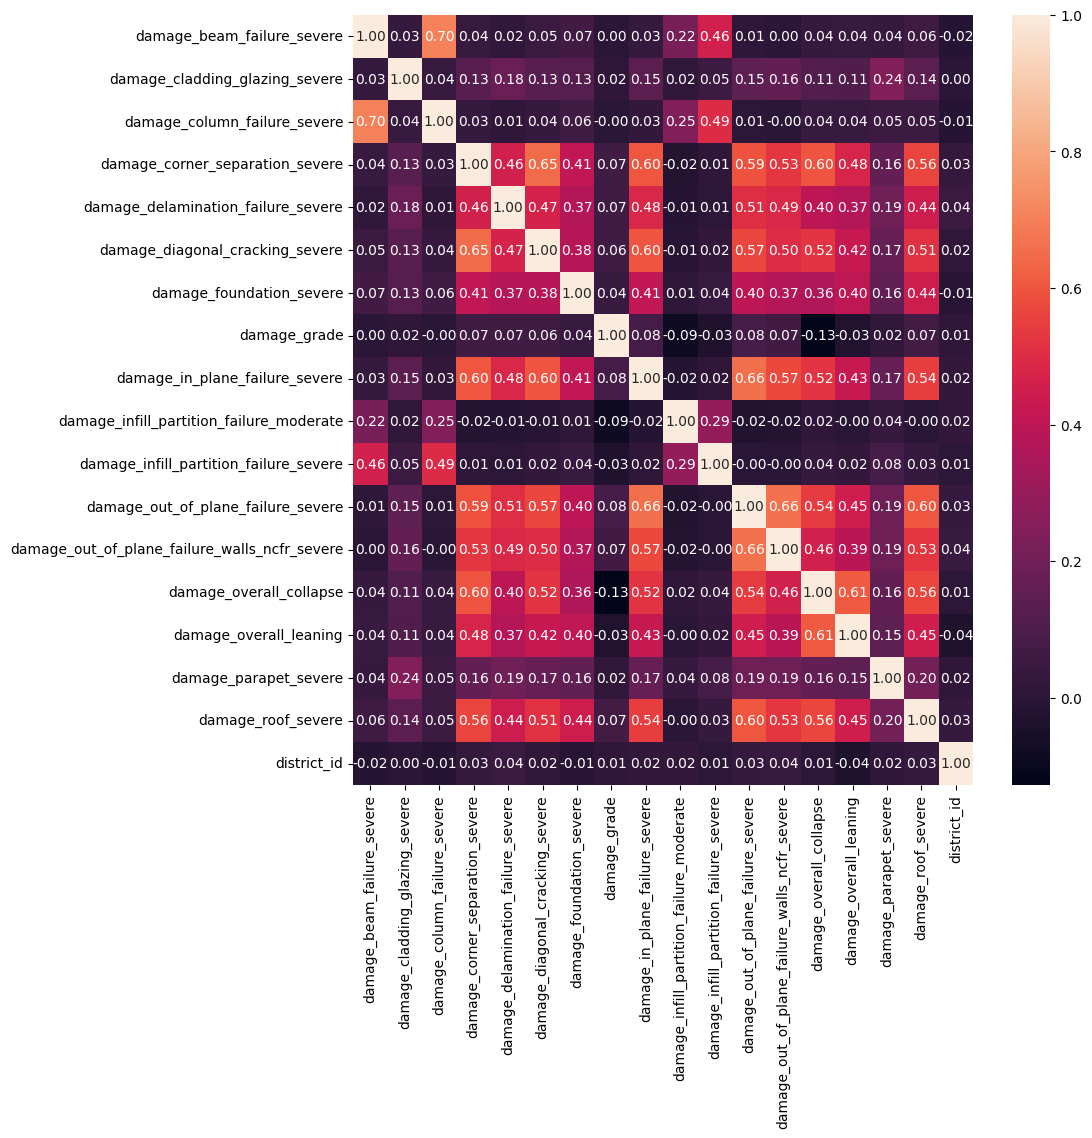

In [16]:
# make a correlation matrix of columns of clustering_df_no_b_id with damage_grade
# ignore vdcmun_name and district_name and area_assessed
# Select columns to include in the correlation matrix
columns_to_include = clustering_df_no_b_id.columns.difference(['vdcmun_name', 'district_name', 'area_assesed'])

# Calculate the correlation matrix
correlation_matrix = clustering_df_no_b_id[columns_to_include].corr()

# Display the correlation matrix
print(correlation_matrix['damage_grade'])
# plot this
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()